In [45]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from retinaface import RetinaFace

In [46]:
# Punto 2: Definir el dataset de puntos característicos de rostros
class FaceKeypointsDataset:
    def __init__(self, csv_file, root_dir):
        self.keypoints_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir

    def __len__(self):
        return len(self.keypoints_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.keypoints_frame.iloc[idx, 0])
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        keypoints = self.keypoints_frame.iloc[idx, 1:].values.astype('float').reshape(-1, 2)
        return {'image': image, 'keypoints': keypoints}

In [47]:
# Función para convertir el dataset en tensores
def dataset_to_tensor(dataset):
    images = []
    keypoints = []
    
    for i in range(len(dataset)):
        sample = dataset[i]
        images.append(sample['image'])
        keypoints.append(sample['keypoints'])
    
    images = np.array(images)
    keypoints = np.array(keypoints).reshape(len(keypoints), -1)
    
    return images, keypoints

In [48]:
# Función para ajustar los puntos clave a una nueva dimensión de imagen
def ajustar_keypoints(keypoints, old_shape, new_shape):
    old_h, old_w = old_shape
    new_h, new_w = new_shape
    scale_x = new_w / old_w
    scale_y = new_h / old_h
    adjusted_keypoints = keypoints * np.array([scale_x, scale_y])
    return adjusted_keypoints

In [49]:
# Función para preprocesar una imagen y sus keypoints
def preprocess_image(image, keypoints):
    faces = RetinaFace.detect_faces(image)
    
    if isinstance(faces, dict) and len(faces) > 0:
        # Encontrar la cara más grande
        largest_face = None
        largest_area = 0
        for key in faces.keys():
            facial_area = faces[key]['facial_area']
            x1, y1, x2, y2 = facial_area
            area = (x2 - x1) * (y2 - y1)
            if area > largest_area:
                largest_area = area
                largest_face = faces[key]

        if largest_face:
            facial_area = largest_face['facial_area']
            x1, y1, x2, y2 = facial_area

            # Recortar la imagen de acuerdo con la detección de la cara
            cropped_image = image[y1:y2, x1:x2]

            # Redimensionar la imagen recortada a 256x256
            resized_image = cv2.resize(cropped_image, (256, 256))

            # Ajustar los puntos clave originales para que coincidan con la nueva imagen redimensionada
            keypoints_adjusted = keypoints - np.array([x1, y1])
            keypoints_adjusted = ajustar_keypoints(keypoints_adjusted, cropped_image.shape[:2], (256, 256))

            # Normalizar la imagen y los puntos clave
            resized_image = resized_image / 255.0
            keypoints_adjusted = keypoints_adjusted / 256.0

            return resized_image, keypoints_adjusted
    else:
        print("No se detectó ninguna cara en la imagen o el retorno no es un diccionario.")
        return None, None

In [50]:
# Función para preprocesar un dataset completo
def preprocess_dataset(images, keypoints):
    preprocessed_images = []
    preprocessed_keypoints = []

    for i in range(len(images)):
        preprocessed_image, preprocessed_keypoint = preprocess_image(images[i], keypoints[i].reshape(-1, 2))
        if preprocessed_image is not None:
            preprocessed_images.append(preprocessed_image)
            preprocessed_keypoints.append(preprocessed_keypoint)

    return np.array(preprocessed_images), np.array(preprocessed_keypoints).reshape(-1, 68 * 2)

In [51]:
# Función para mostrar una imagen y sus puntos clave ajustados
def mostrar_resultado(image, keypoints, title="Imagen con puntos clave ajustados"):
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.scatter(keypoints[:, 0], keypoints[:, 1], c='r', marker='o')
    plt.title(title)
    plt.axis('on')
    plt.gca().invert_yaxis()  # Invertir el eje Y para que coincida con la representación de la imagen

    # Ajustar los límites del eje para que coincidan con la imagen
    plt.xlim(0, image.shape[1])
    plt.ylim(image.shape[0], 0)

    # Mostrar el gráfico
    plt.show()

In [52]:
# Cargar los datasets
train_dataset = FaceKeypointsDataset(csv_file='FaceKPoints/training_frames_keypoints.csv', root_dir='FaceKPoints/training')
valid_dataset = FaceKeypointsDataset(csv_file='FaceKPoints/valid_frames_keypoints.csv', root_dir='FaceKPoints/valid')
#test_dataset = FaceKeypointsDataset(csv_file='FaceKPoints/test_frames_keypoints.csv', root_dir='FaceKPoints/test')

In [53]:
# Convertir los datasets a tensores
train_images, train_keypoints = dataset_to_tensor(train_dataset)
valid_images, valid_keypoints = dataset_to_tensor(valid_dataset)
#test_images, test_keypoints = dataset_to_tensor(test_dataset)

In [54]:
# Preprocesar los datos de entrenamiento
preprocessed_train_images, preprocessed_train_keypoints = preprocess_dataset(train_images, train_keypoints)

No se detectó ninguna cara en la imagen o el retorno no es un diccionario.
No se detectó ninguna cara en la imagen o el retorno no es un diccionario.
No se detectó ninguna cara en la imagen o el retorno no es un diccionario.
No se detectó ninguna cara en la imagen o el retorno no es un diccionario.
No se detectó ninguna cara en la imagen o el retorno no es un diccionario.
No se detectó ninguna cara en la imagen o el retorno no es un diccionario.


In [55]:
# Preprocesar los datos de validación
preprocessed_valid_images, preprocessed_valid_keypoints = preprocess_dataset(valid_images, valid_keypoints)

In [56]:
# Preprocesar los datos de test
#preprocessed_test_images, preprocessed_test_keypoints = preprocess_dataset(test_images, test_keypoints)

In [57]:
# Guardar los datos de entrenamiento pre-procesados
np.save('preprocessed_train_images.npy', preprocessed_train_images)
np.save('preprocessed_train_keypoints.npy', preprocessed_train_keypoints)

In [58]:
# Guardar los datos de validación pre-procesados
np.save('preprocessed_valid_images.npy', preprocessed_valid_images)
np.save('preprocessed_valid_keypoints.npy', preprocessed_valid_keypoints)

In [15]:
# Guardar los datos de validación pre-procesados
#np.save('preprocessed_test_images.npy', preprocessed_test_images)
#np.save('preprocessed_test_keypoints.npy', preprocessed_test_keypoints)

In [59]:
preprocessed_train_images=np.load('preprocessed_train_images.npy')
preprocessed_train_keypoints =np.load('preprocessed_train_keypoints.npy')

preprocessed_valid_images=np.load('preprocessed_valid_images.npy')
preprocessed_valid_keypoints =np.load('preprocessed_valid_keypoints.npy')

#preprocessed_test_images=np.load('preprocessed_test_images.npy')
#preprocessed_test_keypoints =np.load('preprocessed_test_keypoints.npy')

In [63]:
preprocessed_train_images.shape

(3456, 256, 256, 3)

In [65]:
preprocessed_train_keypoints.shape

(3456, 136)

In [66]:
# Cargar los datos preprocesados
preprocessed_train_images = np.load('preprocessed_train_images.npy', allow_pickle=True)
preprocessed_train_keypoints = np.load('preprocessed_train_keypoints.npy', allow_pickle=True)

# Crear una máscara booleana para seleccionar solo los elementos válidos
valid_indices = [i for i, img in enumerate(preprocessed_train_images) if img is not None]

# Filtrar las imágenes y los keypoints usando la máscara booleana
filtered_train_images = np.array([preprocessed_train_images[i] for i in valid_indices])
filtered_train_keypoints = np.array([preprocessed_train_keypoints[i] for i in valid_indices])

# Confirmar las formas de los arrays filtrados
print(filtered_train_images.shape)
print(filtered_train_keypoints.shape)

(3456, 256, 256, 3)
(3456, 136)


In [60]:
# Función para mostrar una imagen y sus puntos clave ajustados
def mostrar_resultado(image, keypoints, title="Imagen con puntos clave ajustados"):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.scatter(keypoints[:, 0] * 256, keypoints[:, 1] * 256, c='r', marker='o')
    plt.title(title)
    plt.axis('on')
    plt.gca().invert_yaxis()  # Invertir el eje Y para que coincida con la representación de la imagen

    # Ajustar los límites del eje para que coincidan con la imagen
    plt.xlim(0, 256)
    plt.ylim(256, 0)

    # Mostrar el gráfico
    plt.show()

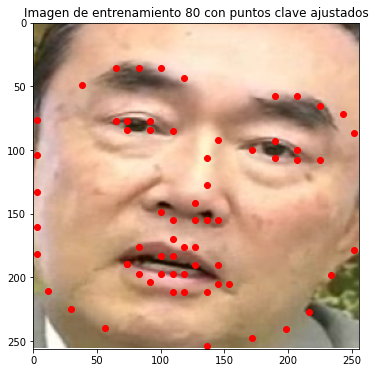

In [61]:
# Ejemplo de llamada a la función con una imagen de entrenamiento
indice_train = 80
image = preprocessed_train_images[indice_train]
keypoints = preprocessed_train_keypoints[indice_train].reshape(-1, 2)
mostrar_resultado(image, keypoints, title=f"Imagen de entrenamiento {indice_train} con puntos clave ajustados")

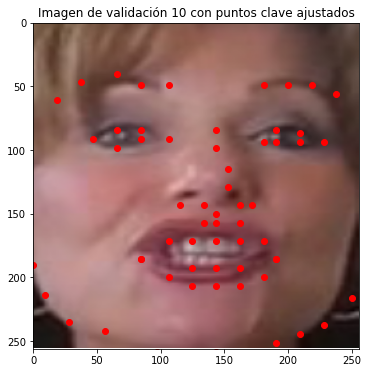

In [62]:
# Ejemplo de llamada a la función con una imagen de validación
indice_valid = 10
image = preprocessed_valid_images[indice_valid]
keypoints = preprocessed_valid_keypoints[indice_valid].reshape(-1, 2)
mostrar_resultado(image, keypoints, title=f"Imagen de validación {indice_valid} con puntos clave ajustados")

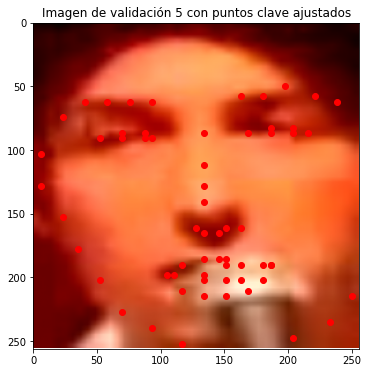

In [24]:
# Ejemplo de llamada a la función con una imagen de validación
indice_test = 5
image = preprocessed_test_images[indice_test]
keypoints = preprocessed_test_keypoints[indice_test].reshape(-1, 2)
mostrar_resultado(image, keypoints, title=f"Imagen de validación {indice_test} con puntos clave ajustados")